# Analysis functions

In [1]:
import numpy as np
from scipy.optimize import fsolve
import datetime
import json
from nupack import *
from matplotlib import pyplot as plt
import re
import pandas as pd
from sklearn.linear_model import LinearRegression

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
def completion_at_time(data,
                      baseline_data,
                      triggered_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      baseline_conditions,
                      triggered_conditions,
                      experimental_level,
                      base_line_level,
                      triggered_level,
                      verbose = False):


  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(baseline_data, baseline_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(triggered_data, triggered_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)

def lookupCondition(columnHeader, conds):
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out

def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

def timeToSec(time_string):
  split_string = time_string.split(":")
  return int(split_string[0])*3600 + int(split_string[1])*60 + int(split_string[2])


  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)


# Importing data

In [5]:
UW_backgr = pd.read_csv("UW_backgr.csv")
conditions_UW_backgr = {'R alone' : ['B2', 'C2', 'D2'],
'N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B3', 'C3', 'D3'],
'R(nn) alone' : ['E2', 'F2', 'G2'],
'N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E3', 'F3', 'G3']}
offset_UW_backgr = 0
t_UW_backgr = [offset_UW_backgr  + timeToSec(i) for i in list(UW_backgr['Time'].values)]
UW_trig = pd.read_csv("UW_trig.csv")
conditions_UW_trig = {'R background' : ['E9', 'F9', 'G9'],
              'no background nat' : ['E13', 'F13', 'G13'],
              'Trig N50_25uM nat' : ['E11', 'F11', 'G11'],
              'R(nn) background' : ['H9', 'I9', 'J9'],
              'no background nn' : ['H13', 'I13', 'J13'],
              'Trig N50_25uM nn' : ['H11', 'I11', 'J11']}
offset_UW_trig = 140
t_UW_trig = [offset_UW_trig  + timeToSec(i) for i in list(UW_trig['Time'].values)]


UW_rep = pd.read_csv("UW_rep.csv")
conditions_UW_rep = {'R background' : ['E8', 'F8', 'G8'],
              'no background nat' : ['E12', 'F12', 'G12'],
              'Rep N50_25uM nat' : ['E10', 'F10', 'G10'],
              'R(nn) background' : ['H8', 'I8', 'J8'],
              'no background nn' : ['H12', 'I12', 'J12'],
              'Rep N50_25uM nn' : ['H10', 'I10', 'J10']}
offset_UW_rep = 140
t_UW_rep = [offset_UW_rep + timeToSec(i) for i in list(UW_rep['Time'].values)]


UW_no = pd.read_csv("UW_no.csv")
conditions_UW_no = {'no background nat' : ['E3', 'F3', 'G3'],
'R background' : ['E4', 'F4', 'G4'],
'No N50_25uM nat' : ['E5', 'F5', 'G5'],
'no background nn' : ['H3', 'I3', 'J3'],
'R(nn) background' : ['H4', 'I4', 'J4'],
'No N50_25uM nn' : ['H5', 'I5', 'J5']}
offset_UW_no = 140
t_UW_no = [offset_UW_no + timeToSec(i) for i in list(UW_no['Time'].values)]

TUM_controls = pd.read_csv("TUM_controls.csv")
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3'],
                          'no background nat' : ['OneStep_1',	'OneStep_2',	'OneStep_3'],
                          'no background nn' : ['OneStep(nn)_1',	'OneStep(nn)_2',	'OneStep(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_no = pd.read_csv("TUM_no.csv")
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]

TUM_trig = pd.read_csv("TUM_trig.csv")
conditions_TUM_trig = {'Trig inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Trig inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Trig inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Trig inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Trig inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Trig inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Trig inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Trig inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_rep = pd.read_csv("TUM_rep.csv")
conditions_TUM_rep = {'Rep inc nat N25-10uM' : ['Trig inc N25-10µM_1',	'Trig inc N25-10µM_2',	'Trig inc N25-10µM_3'],
                       'Rep inc nat N25-25uM' : ['Trig inc N25-25µM_1',	'Trig inc N25-25µM_2',	'Trig inc N25-25µM_3'],
                       'Rep inc nat N50-10uM' : ['Trig inc N50-10µM_1',	'Trig inc N50-10µM_2',	'Trig inc N50-10µM_3'],
                       'Rep inc nat N50-25uM' : ['Trig inc N50-25µM_1',	'Trig inc N50-25µM_2',	'Trig inc N50-25µM_3'],
                       'Rep inc nn N25-10uM' : ['Trig inc N25-10µM(nn)_1',	'Trig inc N25-10µM(nn)_2',	'Trig inc N25-10µM(nn)_3'],
                       'Rep inc nn N25-25uM' : ['Trig inc N25-25µM(nn)_1',	'Trig inc N25-25µM(nn)_2',	'Trig inc N25-25µM(nn)_3'],
                       'Rep inc nn N50-10uM' : ['Trig inc N50-10µM(nn)_1',	'Trig inc N50-10µM(nn)_2',	'Trig inc N50-10µM(nn)_3'],
                       'Rep inc nn N50-25uM' : ['Trig inc N50-25µM(nn)_1',	'Trig inc N50-25µM(nn)_2',	'Trig inc N50-25µM(nn)_3'],
                       }
offset_TUM_rep = 0
t_TUM_rep = [int(t) + offset_TUM_rep for t in TUM_rep['time'].values]



TUM_RNA = pd.read_csv("TUM_RNA.csv")
conditions_TUM_RNA = {'no inc': ['no inc1', 'no inc2', 'no inc3'],
                     'no inc_nn': ['no inc_nn1', 'no inc_nn2', 'no inc_nn3'],
                     'trig inc': ['trig inc1', 'trig inc2', 'trig inc3'],
                     'trig inc_nn': ['trig inc_nn1', 'trig inc_nn2', 'trig inc_nn3'],
                     'cascade inc': ['cascade inc1', 'cascade inc2', 'cascade inc3'],
                     'cascade inc_nn': ['cascade inc_nn1', 'cascade inc_nn2', 'cascade inc_nn3']
                     }
offset_TUM_RNA = 0

t_TUM_RNA = [int(t) + offset_TUM_RNA for t in TUM_RNA['time'].values]


# Processing TUM data

## No incubation

In [6]:
t = t_TUM_controls
data = TUM_controls
conditions = conditions_TUM_controls
levels = list(conditions.keys())
dfArray = []
for i,l in enumerate(levels):
    dfArray.append(getEndpoint(l, t, data, conditions))
    dfArray.append(getInitial(l, t, data, conditions))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,buffer alone init,3814.1,3772.2,3785.4,3790.566667,17.491395
2,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
3,R alone init,3883.9,3918.2,3783.9,3862.000000,56.972684
4,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
5,R(nn) alone init,3981.6,4158.3,3851.2,3997.033333,125.847112
6,no background nat,17875.9,19153.7,19342.4,18790.666667,651.408967
7,no background nat init,5524.4,5628.2,5757.2,5636.600000,95.225627
8,no background nn,17725.8,18529.4,18233.5,18162.900000,331.844853
9,no background nn init,7336.6,7511.6,7420.1,7422.766667,71.468330


In [7]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

N25_10uM nat : 0.8251505929456968 +/- 0.009131375605612805
N25_25uM nat : 0.5546219241783595 +/- 0.030168551243028332
N50_10uM nat : 0.1922113597802375 +/- 0.04517055260590137
N50_25uM nat : 0.08255455908360486 +/- 0.012333315104358145
N25_10uM nn : 0.9832981369374441 +/- 0.03055038152303161
N25_25uM nn : 0.9162138063728941 +/- 0.007378457089329109
N50_10uM nn : 0.7044488244403772 +/- 0.047213679166260486
N50_25uM nn : 0.3431930170350556 +/- 0.03252152058990273
diff_N25-10uM: 0.15814754399174724 +/- 0.03188585629481466
diff_N25-25uM: 0.36159188219453453 +/- 0.031057738377452685
diff_N50-10uM: 0.5122374646601396 +/- 0.06534149005905117
diff_N50-25uM: 0.26063845795145074 +/- 0.03478160380061356


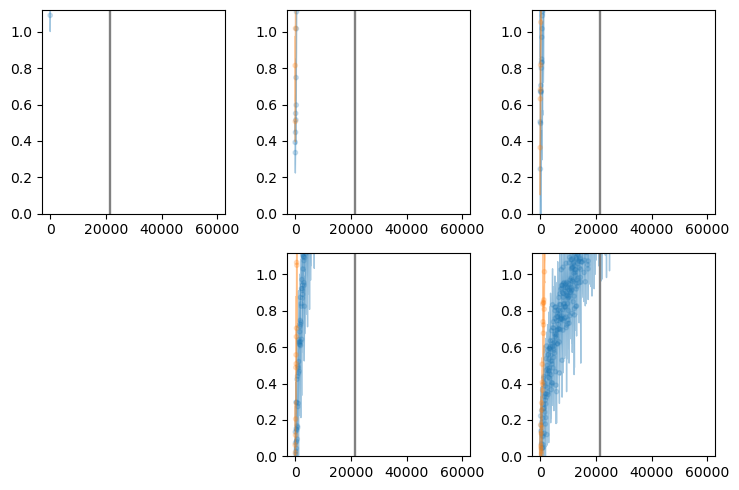

In [8]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_no
data = TUM_no
conditions = conditions_TUM_no

controls = TUM_controls
conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_no.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'no background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1


scale = 1

fit_norm_nat = [3962.800000, (18790.666667-3962.800000)/20]
fit_norm_nn =  [4076.666667, (18162.900000-4076.666667)/20]
fits_norm = [fit_norm_nat, fit_norm_nn]
dfArray = []

t = [i/scale for i in t]

data['time'] = t

for i,l in enumerate(levels):
    fit = fits_norm[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits_norm[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)



for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
        if not((i,j) == (1,0)):
          a.axvline(x= time_point/scale, color = 'gray')
          a.set_ylim(0,1.12)
        else:
          ax[i][j].set_visible(False)


plt.tight_layout()

TUM_no_nat_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N25_10uM nat', 'R alone', 'no background nat' , verbose = True)
TUM_no_nat_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls, 'N25_25uM nat','R alone', 'no background nat', verbose = True)
TUM_no_nat_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N50_10uM nat','R alone', 'no background nat',  verbose = True)
TUM_no_nat_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N50_25uM nat','R alone', 'no background nat',  verbose = True)
TUM_no_nn_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N25_10uM nn','R(nn) alone', 'no background nn',  verbose = True)
TUM_no_nn_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N25_25uM nn','R(nn) alone', 'no background nn',  verbose = True)
TUM_no_nn_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N50_10uM nn','R(nn) alone', 'no background nn',  verbose = True)
TUM_no_nn_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'N50_25uM nn','R(nn) alone', 'no background nn',  verbose = True)
TUM_no_diff_N25_10uM = [(TUM_no_nn_N25_10uM[0] - TUM_no_nat_N25_10uM[0]), np.sqrt(TUM_no_nn_N25_10uM[1]**2 + TUM_no_nat_N25_10uM[1]**2)]
TUM_no_diff_N25_25uM = [(TUM_no_nn_N25_25uM[0] - TUM_no_nat_N25_25uM[0]), np.sqrt(TUM_no_nn_N25_25uM[1]**2 + TUM_no_nat_N25_25uM[1]**2)]
TUM_no_diff_N50_10uM = [(TUM_no_nn_N50_10uM[0] - TUM_no_nat_N50_10uM[0]), np.sqrt(TUM_no_nn_N50_10uM[1]**2 + TUM_no_nat_N50_10uM[1]**2)]
TUM_no_diff_N50_25uM = [(TUM_no_nn_N50_25uM[0] - TUM_no_nat_N50_25uM[0]), np.sqrt(TUM_no_nn_N50_25uM[1]**2 + TUM_no_nat_N50_25uM[1]**2)]
print(f"diff_N25-10uM: {TUM_no_diff_N25_10uM[0]} +/- {TUM_no_diff_N25_10uM[1]}")
print(f"diff_N25-25uM: {TUM_no_diff_N25_25uM[0]} +/- {TUM_no_diff_N25_25uM[1]}")
print(f"diff_N50-10uM: {TUM_no_diff_N50_10uM[0]} +/- {TUM_no_diff_N50_10uM[1]}")
print(f"diff_N50-25uM: {TUM_no_diff_N50_25uM[0]} +/- {TUM_no_diff_N50_25uM[1]}")

## Trigger incubation

In [9]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

Trig inc nat N25-10uM : 0.8113256667833705 +/- 0.013150753403237595
Trig inc nat N25-25uM : 0.5810598511576132 +/- 0.025010655379133384
Trig inc nat N50-10uM : 0.17553616475002912 +/- 0.004668912120241908
Trig inc nat N50-25uM : 0.06040325693715041 +/- 0.008278113589502029
Trig inc nn N25-10uM : 0.9934112346895677 +/- 0.008369936792412972
Trig inc nn N25-25uM : 0.9138204514524378 +/- 0.03125156327477792
Trig inc nn N50-10uM : 0.6017926697639494 +/- 0.005683197790755497
Trig inc nn N50-25uM : 0.23535126003097281 +/- 0.006877631529254812
diff_N25-10uM: 0.18208556790619723 +/- 0.01558839815316999
diff_N25-25uM: 0.3327606002948247 +/- 0.04002740423274062
diff_N50-10uM: 0.4262565050139203 +/- 0.0073550987427355415
diff_N50-25uM: 0.1749480030938224 +/- 0.010762387284097244


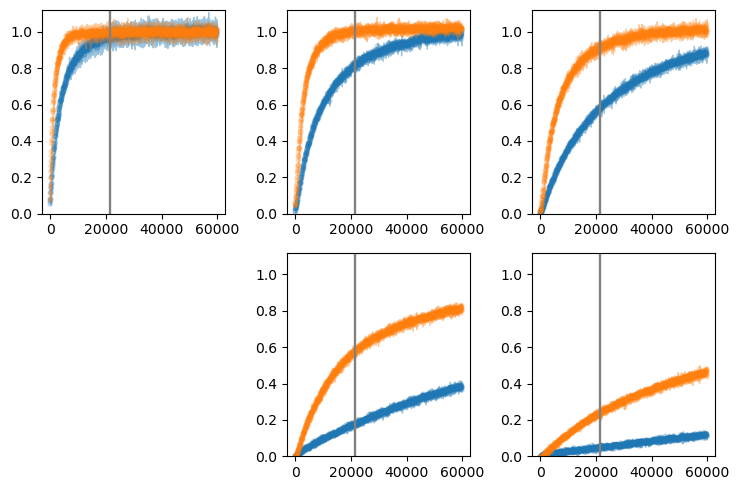

In [10]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_trig
data = TUM_trig
conditions = conditions_TUM_trig

controls = TUM_controls
conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_trig.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'trig background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1



fit_trigrm_nat = [3962.800000, (18790.666667-3962.800000)]
fit_trigrm_nn =  [4076.666667, (18162.900000-4076.666667)]
fits_trigrm = [fit_trigrm_nat, fit_trigrm_nn]
dfArray = []
for i,l in enumerate(levels):
    fit = fits_trigrm[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits_trigrm[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
        if not((i,j) == (1,0)):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,1.12)
        else:
          ax[i][j].set_visible(False)


plt.tight_layout()

TUM_trig_nat_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nat N25-10uM', 'R alone', 'no background nat' , verbose = True)
TUM_trig_nat_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls, 'Trig inc nat N25-25uM','R alone', 'no background nat', verbose = True)
TUM_trig_nat_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nat N50-10uM','R alone', 'no background nat',  verbose = True)
TUM_trig_nat_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nat N50-25uM','R alone', 'no background nat',  verbose = True)
TUM_trig_nn_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nn N25-10uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_trig_nn_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nn N25-25uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_trig_nn_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nn N50-10uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_trig_nn_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Trig inc nn N50-25uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_trig_diff_N25_10uM = [(TUM_trig_nn_N25_10uM[0] - TUM_trig_nat_N25_10uM[0]), np.sqrt(TUM_trig_nn_N25_10uM[1]**2 + TUM_trig_nat_N25_10uM[1]**2)]
TUM_trig_diff_N25_25uM = [(TUM_trig_nn_N25_25uM[0] - TUM_trig_nat_N25_25uM[0]), np.sqrt(TUM_trig_nn_N25_25uM[1]**2 + TUM_trig_nat_N25_25uM[1]**2)]
TUM_trig_diff_N50_10uM = [(TUM_trig_nn_N50_10uM[0] - TUM_trig_nat_N50_10uM[0]), np.sqrt(TUM_trig_nn_N50_10uM[1]**2 + TUM_trig_nat_N50_10uM[1]**2)]
TUM_trig_diff_N50_25uM = [(TUM_trig_nn_N50_25uM[0] - TUM_trig_nat_N50_25uM[0]), np.sqrt(TUM_trig_nn_N50_25uM[1]**2 + TUM_trig_nat_N50_25uM[1]**2)]
print(f"diff_N25-10uM: {TUM_trig_diff_N25_10uM[0]} +/- {TUM_trig_diff_N25_10uM[1]}")
print(f"diff_N25-25uM: {TUM_trig_diff_N25_25uM[0]} +/- {TUM_trig_diff_N25_25uM[1]}")
print(f"diff_N50-10uM: {TUM_trig_diff_N50_10uM[0]} +/- {TUM_trig_diff_N50_10uM[1]}")
print(f"diff_N50-25uM: {TUM_trig_diff_N50_25uM[0]} +/- {TUM_trig_diff_N50_25uM[1]}")

## Reporter incubation

In [11]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

Rep inc nat N25-10uM : 0.8113256667833705 +/- 0.013150753403237595
Rep inc nat N25-25uM : 0.5810598511576132 +/- 0.025010655379133384
Rep inc nat N50-10uM : 0.17553616475002912 +/- 0.004668912120241908
Rep inc nat N50-25uM : 0.06040325693715041 +/- 0.008278113589502029
Rep inc nn N25-10uM : 0.9934112346895677 +/- 0.008369936792412972
Rep inc nn N25-25uM : 0.9138204514524378 +/- 0.03125156327477792
Rep inc nn N50-10uM : 0.6017926697639494 +/- 0.005683197790755497
Rep inc nn N50-25uM : 0.23535126003097281 +/- 0.006877631529254812
diff_N25-10uM: 0.18208556790619723 +/- 0.01558839815316999
diff_N25-25uM: 0.3327606002948247 +/- 0.04002740423274062
diff_N50-10uM: 0.4262565050139203 +/- 0.0073550987427355415
diff_N50-25uM: 0.1749480030938224 +/- 0.010762387284097244


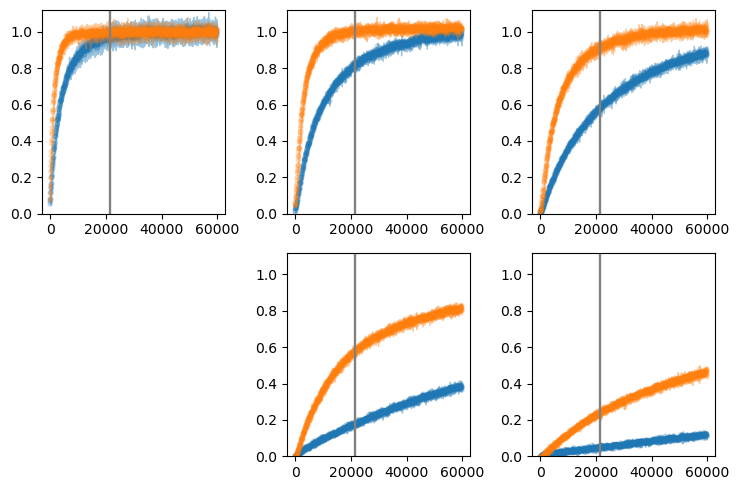

In [12]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_rep
data = TUM_rep
conditions = conditions_TUM_rep

controls = TUM_controls
conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_rep.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'rep background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

fit_reprm_nat = [3962.800000, (18790.666667-3962.800000)]
fit_reprm_nn =  [4076.666667, (18162.900000-4076.666667)]
fits_reprm = [fit_reprm_nat, fit_reprm_nn]
dfArray = []
for i,l in enumerate(levels):
    fit = fits_reprm[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits_reprm[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
        if not((i,j) == (1,0)):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,1.12)
        else:
          ax[i][j].set_visible(False)


plt.tight_layout()

TUM_rep_nat_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nat N25-10uM', 'R alone', 'no background nat' , verbose = True)
TUM_rep_nat_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls, 'Rep inc nat N25-25uM','R alone', 'no background nat', verbose = True)
TUM_rep_nat_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nat N50-10uM','R alone', 'no background nat',  verbose = True)
TUM_rep_nat_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nat N50-25uM','R alone', 'no background nat',  verbose = True)
TUM_rep_nn_N25_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nn N25-10uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_rep_nn_N25_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nn N25-25uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_rep_nn_N50_10uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nn N50-10uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_rep_nn_N50_25uM = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'Rep inc nn N50-25uM','R(nn) alone', 'no background nn',  verbose = True)
TUM_rep_diff_N25_10uM = [(TUM_rep_nn_N25_10uM[0] - TUM_rep_nat_N25_10uM[0]), np.sqrt(TUM_rep_nn_N25_10uM[1]**2 + TUM_rep_nat_N25_10uM[1]**2)]
TUM_rep_diff_N25_25uM = [(TUM_rep_nn_N25_25uM[0] - TUM_rep_nat_N25_25uM[0]), np.sqrt(TUM_rep_nn_N25_25uM[1]**2 + TUM_rep_nat_N25_25uM[1]**2)]
TUM_rep_diff_N50_10uM = [(TUM_rep_nn_N50_10uM[0] - TUM_rep_nat_N50_10uM[0]), np.sqrt(TUM_rep_nn_N50_10uM[1]**2 + TUM_rep_nat_N50_10uM[1]**2)]
TUM_rep_diff_N50_25uM = [(TUM_rep_nn_N50_25uM[0] - TUM_rep_nat_N50_25uM[0]), np.sqrt(TUM_rep_nn_N50_25uM[1]**2 + TUM_rep_nat_N50_25uM[1]**2)]
print(f"diff_N25-10uM: {TUM_rep_diff_N25_10uM[0]} +/- {TUM_rep_diff_N25_10uM[1]}")
print(f"diff_N25-25uM: {TUM_rep_diff_N25_25uM[0]} +/- {TUM_rep_diff_N25_25uM[1]}")
print(f"diff_N50-10uM: {TUM_rep_diff_N50_10uM[0]} +/- {TUM_rep_diff_N50_10uM[1]}")
print(f"diff_N50-25uM: {TUM_rep_diff_N50_25uM[0]} +/- {TUM_rep_diff_N50_25uM[1]}")

## Total RNA

In [13]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]

cascade inc : 1.0172632032533462 +/- 0.010434117179783061
cascade inc_nn : 0.9313511621017478 +/- 0.016855650970406207
trig inc : 0.7327525068900199 +/- 0.008603570558405873
trig inc_nn : 0.6870808758180497 +/- 0.03134274645953321
no inc : 0.815208316501037 +/- 0.01983735631568227
no inc_nn : 0.7790525436966416 +/- 0.02065425126990982

diff rep tot: -0.08591204115159834 +/- 0.01982381827392492
diff trig tot: -0.04567163107197025 +/- 0.03250214119069773
diff no tot: -0.04567163107197025 +/- 0.03250214119069773


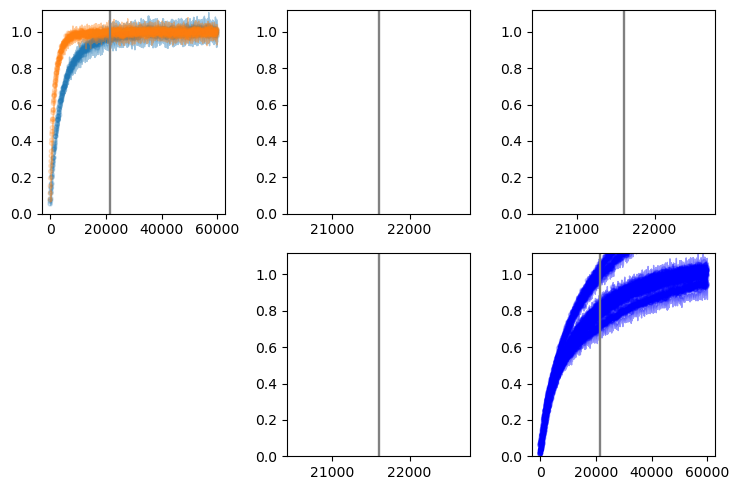

In [18]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_RNA
data = TUM_RNA
conditions = conditions_TUM_RNA

controls = TUM_controls
conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_rep.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'rep background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

fit_reprm_nat = [3962.800000, (18790.666667-3962.800000)]
fit_reprm_nn =  [4076.666667, (18162.900000-4076.666667)]
fits_reprm = [fit_reprm_nat, fit_reprm_nn]
dfArray = []
for i,l in enumerate(levels):
    fit = fits_reprm[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits_reprm[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
        if not((i,j) == (1,0)):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,1.12)
        else:
          ax[i][j].set_visible(False)


plt.tight_layout()

TUM_rep_nat_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls, 'cascade inc', 'R alone', 'no background nat' , verbose = True)
TUM_rep_nn_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'cascade inc_nn', 'R alone', 'no background nat' , verbose = True)
TUM_trig_nat_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'trig inc', 'R alone', 'no background nat' , verbose = True)
TUM_trig_nn_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'trig inc_nn', 'R alone', 'no background nat' , verbose = True)
TUM_no_nat_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'no inc', 'R alone', 'no background nat' , verbose = True)
TUM_no_nn_tot = completion_at_time(data, controls, controls, t, time_point, conditions, conditions_TUM_controls,conditions_TUM_controls,'no inc_nn', 'R alone', 'no background nat' , verbose = True)

TUM_rep_diff_tot = [(TUM_rep_nn_tot[0] - TUM_rep_nat_tot[0]), np.sqrt(TUM_rep_nn_tot[1]**2 + TUM_rep_nat_tot[1]**2)]
TUM_trig_diff_tot = [(TUM_trig_nn_tot[0] - TUM_trig_nat_tot[0]), np.sqrt(TUM_trig_nn_tot[1]**2 + TUM_trig_nat_tot[1]**2)]
TUM_no_diff_tot = [(TUM_no_nn_tot[0] - TUM_no_nat_tot[0]), np.sqrt(TUM_no_nn_tot[1]**2 + TUM_no_nat_tot[1]**2)]
print()
print(f"diff rep tot: {TUM_rep_diff_tot[0]} +/- {TUM_rep_diff_tot[1]}")
print(f"diff trig tot: {TUM_trig_diff_tot[0]} +/- {TUM_trig_diff_tot[1]}")
print(f"diff no tot: {TUM_trig_diff_tot[0]} +/- {TUM_trig_diff_tot[1]}")



# Processing UW data

## No incubation

In [19]:
t = t_UW_no
data = UW_no
conditions = conditions_UW_no
levels = [list(conditions.keys())[i] for i in [0,1,3,4]]
dfArray = []

for i,l in enumerate(levels):
    dfArray.append(getEndpoint(l, t, data, conditions))

t = t_UW_backgr
data = UW_backgr
conditions = conditions_UW_backgr
levels = [list(conditions.keys())[i] for i in [0,2]]
for i,l in enumerate(levels):
    dfArray.append(getEndpoint(l, t, data, conditions))

merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,no background nat,6625.3,6732.0,6747.4,6701.566667,54.293912
1,R background,949.8,931.0,921.2,934.000000,11.867041
2,no background nn,7660.6,7664.5,7629.2,7651.433333,15.801758
3,R(nn) background,369.5,360.0,376.6,368.700000,6.800490
4,R alone,795.4,788.1,784.5,789.333333,4.534559
5,R(nn) alone,275.8,277.0,283.0,278.600000,3.149603


In [11]:
fit_nat = [789.333333, (6701.566667-789.333333)/20]
fit_nn =  [278.600000, (7651.433333	-278.600000)/20]

No N50_25uM nat : 0.2074495077641327 +/- 0.006377672078296619
No N50_25uM nn : 0.6187917763366166 +/- 0.008117302126894994
diff_N25_25uM: 0.4113422685724839 +/- 0.010323046786563466


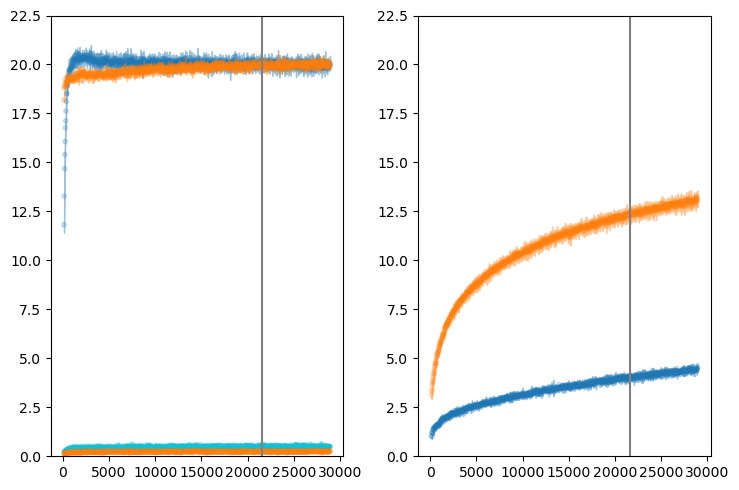

In [12]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_no
data = UW_no
conditions = conditions_UW_no
levels = list(conditions.keys())

fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions.keys()}


def get_plot_num(level):
  if 'no background' in level or 'R' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'nat' in level or 'R ' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind], data, conditions, fit, color_dict, format_dict=format_dict)

for i,a in enumerate(ax):
  a.axvline(x= time_point, color = 'gray')
  a.set_ylim(0,22.5)


plt.tight_layout()


UW_no_nat_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions,'No N50_25uM nat', 'R alone', 'no background nat',  verbose = True)
UW_no_nn_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions, 'No N50_25uM nn', 'R(nn) alone', 'no background nn' ,verbose = True)

UW_no_diff_N50_25uM = [(UW_no_nn_N50_25uM[0] - UW_no_nat_N50_25uM[0]), np.sqrt(UW_no_nn_N50_25uM[1]**2 + UW_no_nat_N50_25uM[1]**2)]
print(f"diff_N25_25uM: {UW_no_diff_N50_25uM[0]} +/- {UW_no_diff_N50_25uM[1]}")

## Trigger incubation

In [13]:
fit_nat = [789.333333, (6701.566667-789.333333)/20]
fit_nn =  [278.600000, (7651.433333	-278.600000)/20]

Trig N50_25uM nat : 0.15669156587497976 +/- 0.0066821312113407826
Trig N50_25uM nn : 0.5243476830872679 +/- 0.009624818977767067
diff_N25_25uM: 0.3676561172122881 +/- 0.01171699696510841


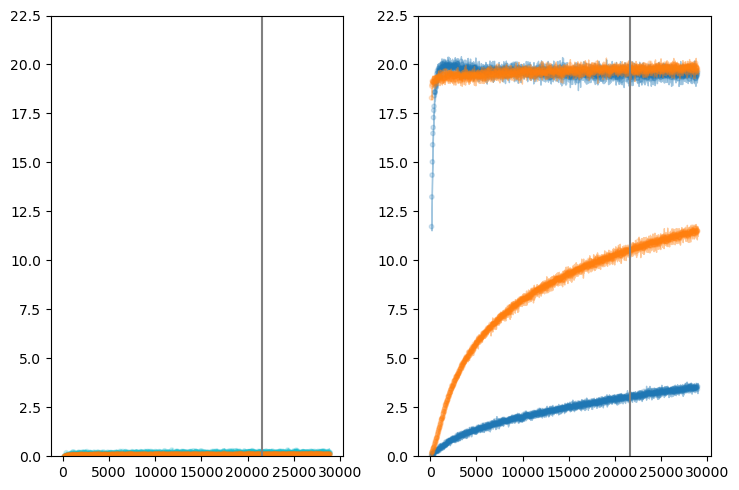

In [14]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_trig
data = UW_trig
conditions = conditions_UW_trig
levels = list(conditions.keys())

fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions.keys()}


def get_plot_num(level):
  if 'trig background' in level or 'R' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'nat' in level or 'R ' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind], data, conditions, fit, color_dict, format_dict=format_dict)

for i,a in enumerate(ax):
  a.axvline(x= time_point, color = 'gray')
  a.set_ylim(0,22.5)


plt.tight_layout()


UW_trig_nat_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions,'Trig N50_25uM nat', 'R alone', 'no background nat',  verbose = True)
UW_trig_nn_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions, 'Trig N50_25uM nn', 'R(nn) alone', 'no background nn' ,verbose = True)

UW_trig_diff_N50_25uM = [(UW_trig_nn_N50_25uM[0] - UW_trig_nat_N50_25uM[0]), np.sqrt(UW_trig_nn_N50_25uM[1]**2 + UW_trig_nat_N50_25uM[1]**2)]
print(f"diff_N25_25uM: {UW_trig_diff_N50_25uM[0]} +/- {UW_trig_diff_N50_25uM[1]}")

## Reporter incubation

In [15]:
fit_nat = [789.333333, (6701.566667-789.333333)/20]
fit_nn =  [278.600000, (7651.433333	-278.600000)/20]

Rep N50_25uM nat : 0.21489951164537943 +/- 0.01208263638460398
Rep N50_25uM nn : 0.6570514588274227 +/- 0.004793707415488154
diff_N25_25uM: 0.4421519471820432 +/- 0.012998835824329117


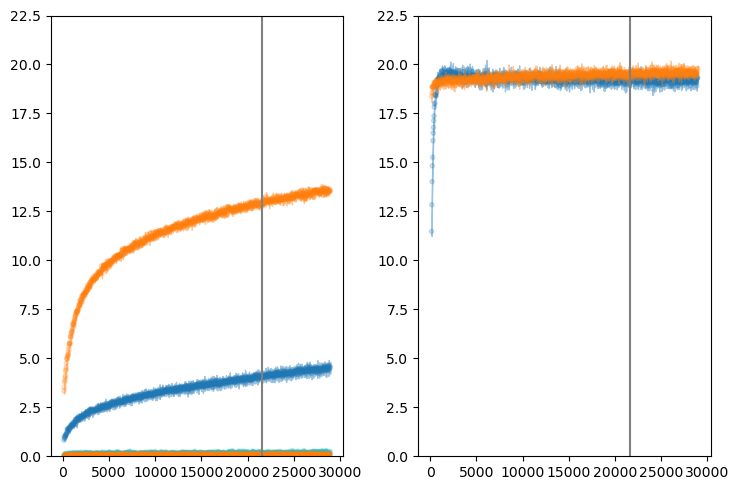

In [16]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_rep
data = UW_rep
conditions = conditions_UW_rep
levels = list(conditions.keys())

fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions.keys()}


def get_plot_num(level):
  if 'rep background' in level or 'R' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'nat' in level or 'R ' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind], data, conditions, fit, color_dict, format_dict=format_dict)

for i,a in enumerate(ax):
  a.axvline(x= time_point, color = 'gray')
  a.set_ylim(0,22.5)


plt.tight_layout()


UW_rep_nat_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions,'Rep N50_25uM nat', 'R alone', 'no background nat',  verbose = True)
UW_rep_nn_N50_25uM = completion_at_time(data, UW_backgr, data, t, time_point, conditions, conditions_UW_backgr, conditions, 'Rep N50_25uM nn', 'R(nn) alone', 'no background nn' ,verbose = True)

UW_rep_diff_N50_25uM = [(UW_rep_nn_N50_25uM[0] - UW_rep_nat_N50_25uM[0]), np.sqrt(UW_rep_nn_N50_25uM[1]**2 + UW_rep_nat_N50_25uM[1]**2)]
print(f"diff_N25_25uM: {UW_rep_diff_N50_25uM[0]} +/- {UW_rep_diff_N50_25uM[1]}")

# Analysis

## TUM only

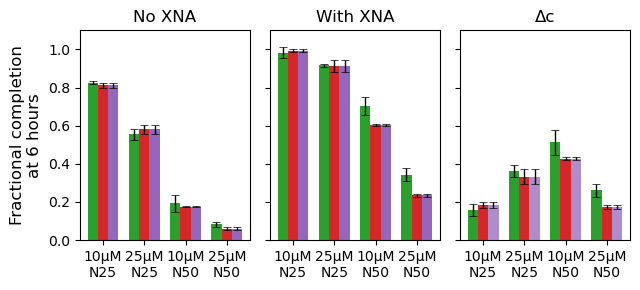

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(6.5)
fig.set_figheight(3)

labels = [u"10\u03bcM\nN25", u"25\u03bcM\nN25", u"10\u03bcM\nN50", u"25\u03bcM\nN50"]
x = np.arange(len(labels))  # [0, 1, 2, 3]
bar_width = 0.25

# Group datasets by color group
datasets_panel0 = [
    # Format: (nat, nn, label, color, marker scale)
    ([TUM_no_nat_N25_10uM, TUM_no_nat_N25_25uM, TUM_no_nat_N50_10uM, TUM_no_nat_N50_25uM],
     [TUM_no_nn_N25_10uM,  TUM_no_nn_N25_25uM,  TUM_no_nn_N50_10uM,  TUM_no_nn_N50_25uM],
      color_scheme[2], 1.0),
    ([TUM_trig_nat_N25_10uM, TUM_trig_nat_N25_25uM, TUM_trig_nat_N50_10uM, TUM_trig_nat_N50_25uM],
     [TUM_trig_nn_N25_10uM,  TUM_trig_nn_N25_25uM,  TUM_trig_nn_N50_10uM,  TUM_trig_nn_N50_25uM],
     color_scheme[3], 1.0),
    ([TUM_rep_nat_N25_10uM, TUM_rep_nat_N25_25uM, TUM_rep_nat_N50_10uM, TUM_rep_nat_N50_25uM],
     [TUM_rep_nn_N25_10uM,  TUM_rep_nn_N25_25uM,  TUM_rep_nn_N50_10uM,  TUM_rep_nn_N50_25uM],
     color_scheme[4], 1),
]

datasets_panel1 = [
    ([TUM_no_diff_N25_10uM, TUM_no_diff_N25_25uM, TUM_no_diff_N50_10uM, TUM_no_diff_N50_25uM], 'No XNA', color_scheme[2], 1.0),
    ([TUM_trig_diff_N25_10uM, TUM_trig_diff_N25_25uM, TUM_trig_diff_N50_10uM, TUM_trig_diff_N50_25uM], 'Trigger XNA', color_scheme[3], 1.0),
    ([TUM_rep_diff_N25_10uM, TUM_rep_diff_N25_25uM, TUM_rep_diff_N50_10uM, TUM_rep_diff_N50_25uM], 'Replicator XNA', color_scheme[4], 0.75),
]


error_params = dict(ecolor='black', lw=1, capsize=3, capthick= 0.5)

for i, (nat_list, nn_list, color, scale) in enumerate(datasets_panel0):
    nat_y = [v[0] for v in nat_list]
    nat_err = [v[1] for v in nat_list]
    nn_y = [v[0] for v in nn_list]
    nn_err = [v[1] for v in nn_list]

    # x positions for this dataset
    dx = (i - 1) * bar_width  # shifts: -bar_width, 0, +bar_width
    ax[0].bar(x + dx, nat_y, width=bar_width, yerr=nat_err, error_kw=error_params,
              color=color, alpha=1.0 * scale)
    ax[1].bar(x + dx, nn_y, width=bar_width, yerr=nn_err, error_kw=error_params,
              color=color, alpha=1 * scale)

# Panel 1: draw diff bars (no pairs)
for i, (diff_list, label, color, scale) in enumerate(datasets_panel1):
    diff_y = [v[0] for v in diff_list]
    diff_err = [v[1] for v in diff_list]
    dx = (i - 1) * bar_width  # shift left, center, right
    ax[2].bar(x + dx, diff_y, width=bar_width, yerr=diff_err, error_kw=error_params,
              color=color, label=label, alpha=scale)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=10)
    a.set_ylim(0, 1.1)
    a.tick_params(axis='x', labelrotation=0)

ax[0].set_ylabel('Fractional completion\nat 6 hours', fontsize=12)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Δc', fontsize=12)


plt.tight_layout()
#plt.savefig('NAR_TUM_Onestep_barplot_err.svg', dpi=600)
plt.show()


# Comparison UW to TUM

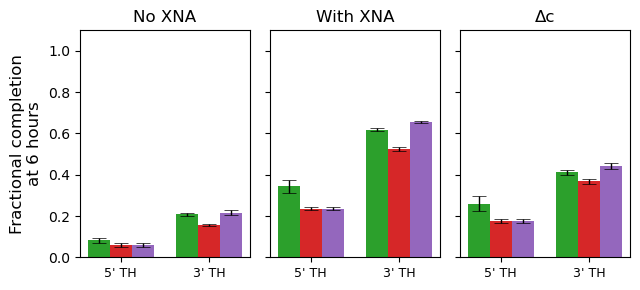

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(6.5)
fig.set_figheight(3)

labels = ["5' TH", "3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

# Panel 0: No XNA
no_nat_data_together = [TUM_no_nat_N50_25uM, UW_no_nat_N50_25uM]
no_nn_data_together = [TUM_no_nn_N50_25uM, UW_no_nn_N50_25uM]
no_diff_data_together = [TUM_no_diff_N50_25uM, UW_no_diff_N50_25uM]

# Panel 1: Trigger XNA
trig_nat_data_together = [TUM_trig_nat_N50_25uM, UW_trig_nat_N50_25uM]
trig_nn_data_together = [TUM_trig_nn_N50_25uM, UW_trig_nn_N50_25uM]
trig_diff_data_together = [TUM_trig_diff_N50_25uM, UW_trig_diff_N50_25uM]

# Panel 2: Replicator XNA
rep_nat_data_together = [TUM_rep_nat_N50_25uM, UW_rep_nat_N50_25uM]
rep_nn_data_together = [TUM_rep_nn_N50_25uM, UW_rep_nn_N50_25uM]
rep_diff_data_together = [TUM_rep_diff_N50_25uM, UW_rep_diff_N50_25uM]

# Grouped data for each condition and panel
datasets_panel0 = [
    (no_nat_data_together, color_scheme[2], -bar_width),
    (trig_nat_data_together, color_scheme[3], 0),
    (rep_nat_data_together, color_scheme[4], bar_width),
]
datasets_panel1 = [
    (no_nn_data_together, color_scheme[2], -bar_width),
    (trig_nn_data_together, color_scheme[3], 0),
    (rep_nn_data_together, color_scheme[4], bar_width),
]
datasets_panel2 = [
    (no_diff_data_together, color_scheme[2], -bar_width),
    (trig_diff_data_together, color_scheme[3], 0),
    (rep_diff_data_together, color_scheme[4], bar_width),
]


error_params = dict(ecolor='black', lw=1, capsize=5, capthick= 0.5)

# Plot nat
for data_list, color, dx in datasets_panel0:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Plot nn
for data_list, color, dx in datasets_panel1:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Plot diff
for data_list, color, dx in datasets_panel2:
    y = [d[0] for d in data_list]
    e = [d[1] for d in data_list]
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color, error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, 1.1)
    a.tick_params(axis='x')

ax[0].set_ylabel('Fractional completion\nat 6 hours', fontsize=12)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Δc', fontsize=12)

plt.tight_layout()
#plt.savefig('NAR_onestep_compare_barplot_err.svg', dpi=400)
plt.show()
